# Crossentropy method

This notebook will teach you to solve reinforcement learning with crossentropy method.

In [1]:
#XVFB will be launched if you run on a server
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

Starting virtual X frame buffer: Xvfb.
env: DISPLAY=:1


In [2]:
from IPython import display

In [3]:
from tqdm import tqdm
from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
import gym
import numpy as np, pandas as pd

env = gym.make("Taxi-v2")
env.reset()
env.render()

[2017-02-26 19:16:31,469] Making new env: Taxi-v2


+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [4]:
n_states = env.observation_space.n
n_actions = env.action_space.n

print("n_states=%i, n_actions=%i"%(n_states,n_actions))

n_states=500, n_actions=6


# Create stochastic policy

This time our policy should be a probability distribution.

```policy[s,a] = P(take action a | in state s)```

Since we still use integer state and action representations, you can use a 2-dimensional array to represent the policy.

Please initialize policy __uniformly__, that is, probabililities of all actions should be equal.


In [5]:
policy = np.ones((n_states, n_actions)) / n_actions

In [6]:
assert type(policy) in (np.ndarray,np.matrix)
assert np.allclose(policy,1./n_actions)
assert np.allclose(np.sum(policy,axis=1), 1)

# Play the game

Just like before, but we also record all states and actions we took.

In [7]:
def generate_session(t_max=10**4):
    """
    Play game until end or for t_max ticks.
    returns: list of states, list of actions and sum of rewards
    """
    states,actions = [],[]
    total_reward = 0.
    
    s = env.reset()
    
    for t in range(t_max):
        
        a = np.random.choice(np.arange(n_actions), p=policy[s])
        
        new_s,r,done,info = env.step(a)
        
        states.append(s)
        actions.append(a)
        total_reward += r
        
        s = new_s
        if done:
            break
    return states,actions,total_reward

In [8]:
s,a,r = generate_session()
assert type(s) == type(a) == list
assert len(s) == len(a)
assert type(r) is float

# Training loop
Generate sessions, select N best and fit to those.

In [21]:
policy = np.ones((n_states, n_actions)) / n_actions

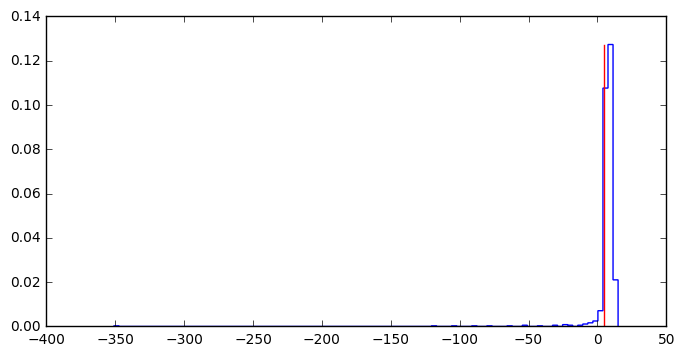

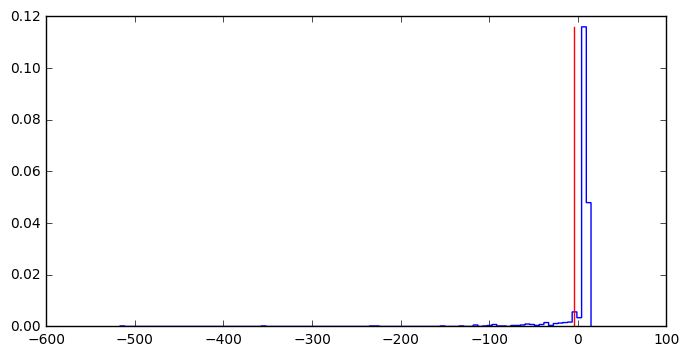

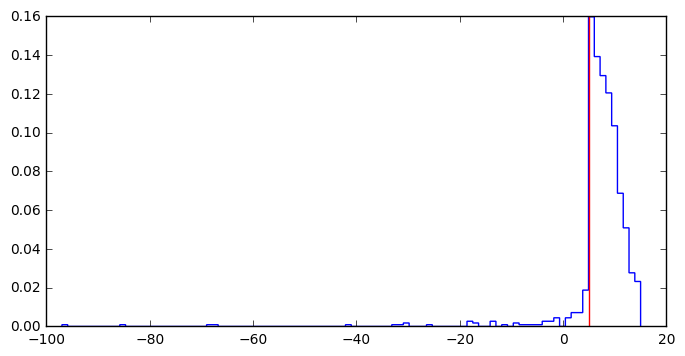

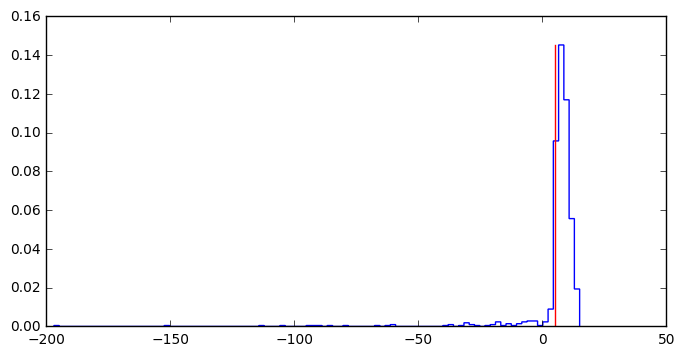

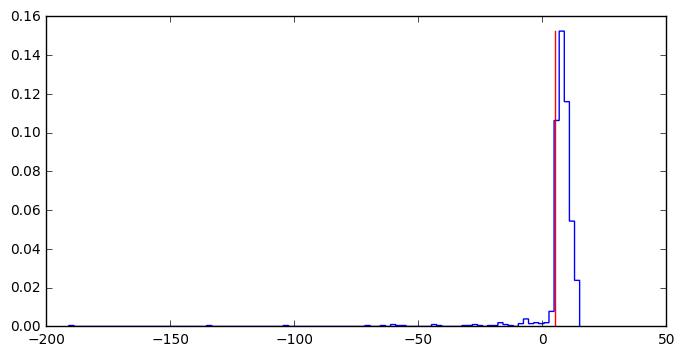

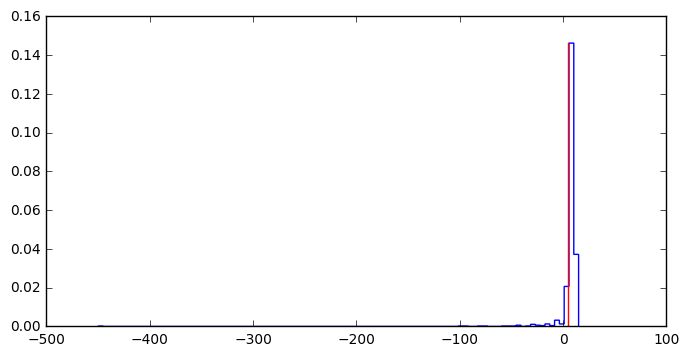

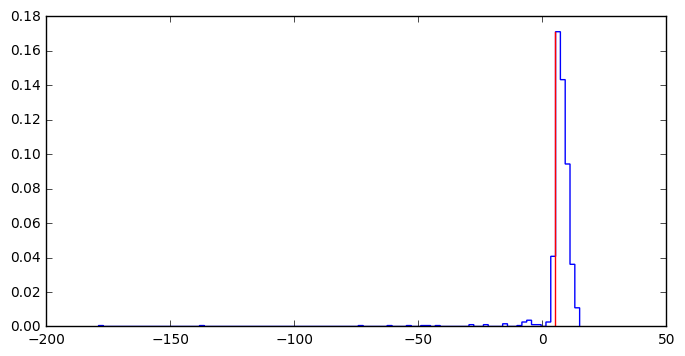

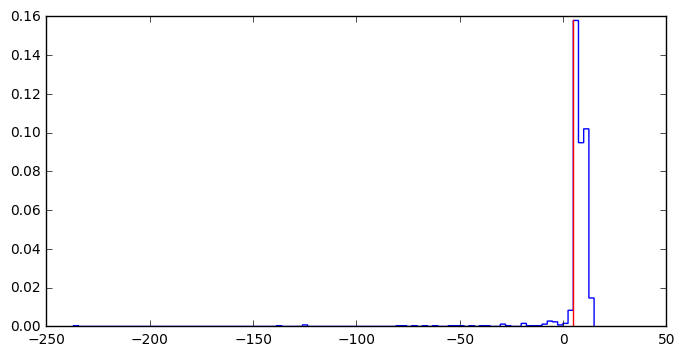

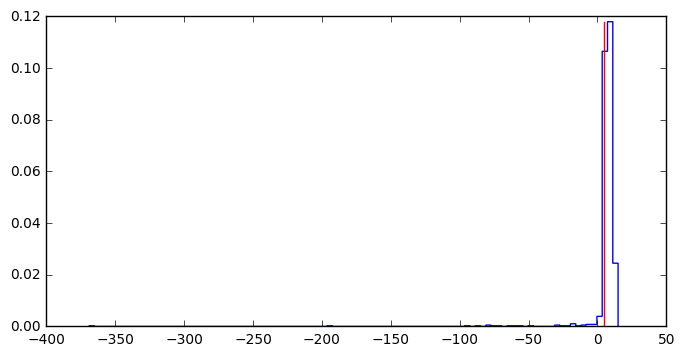

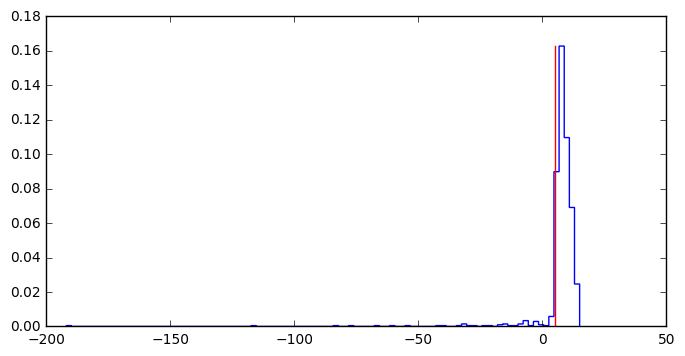

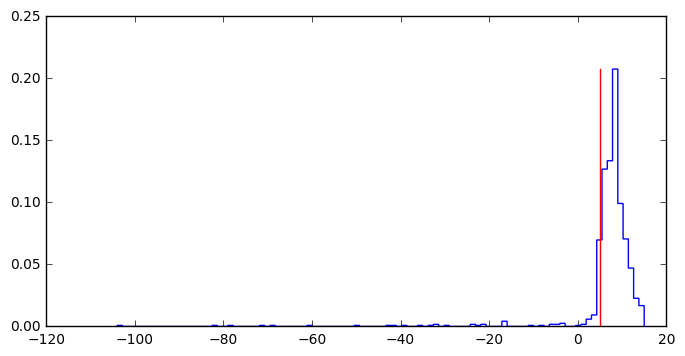

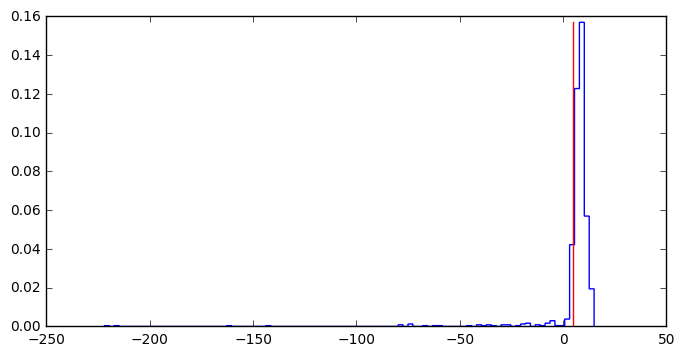

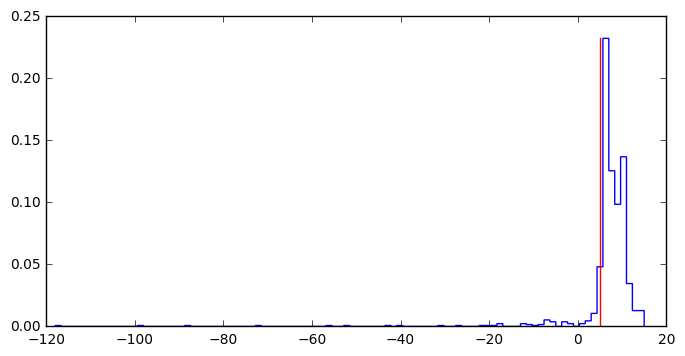

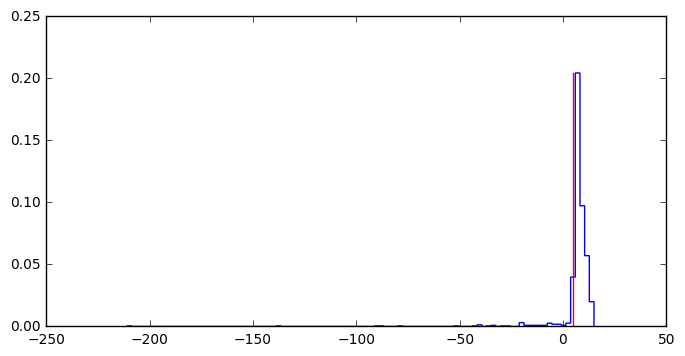

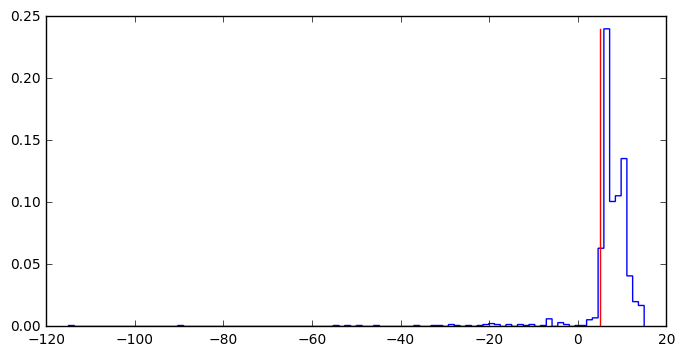

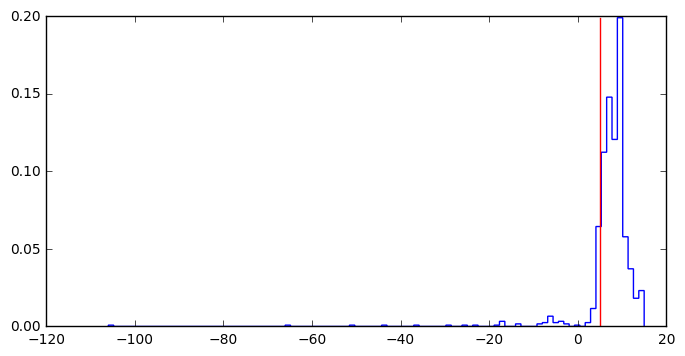

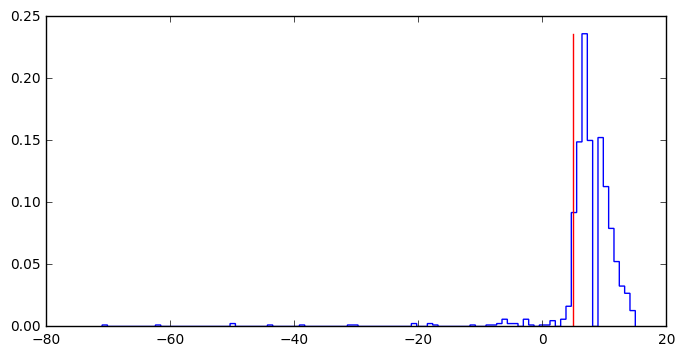

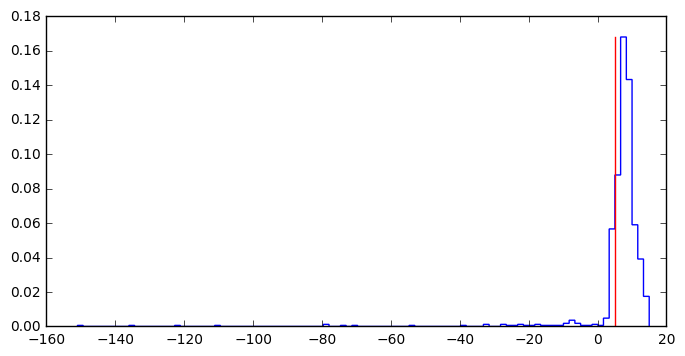

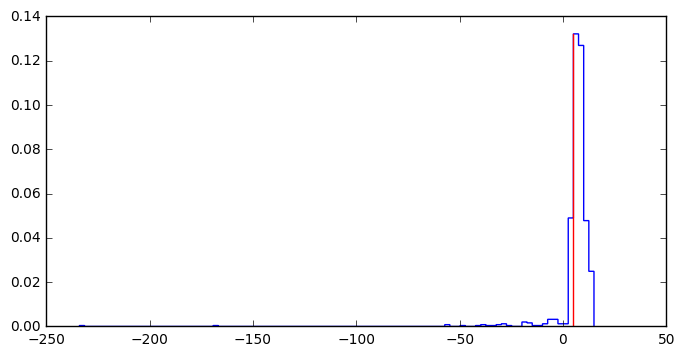

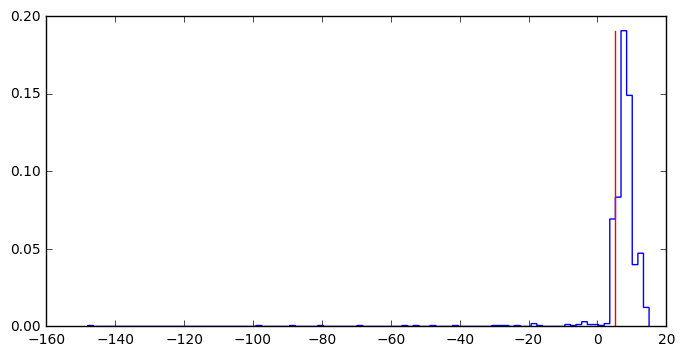

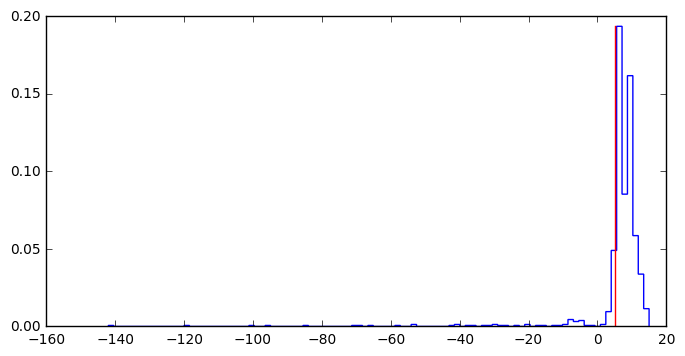

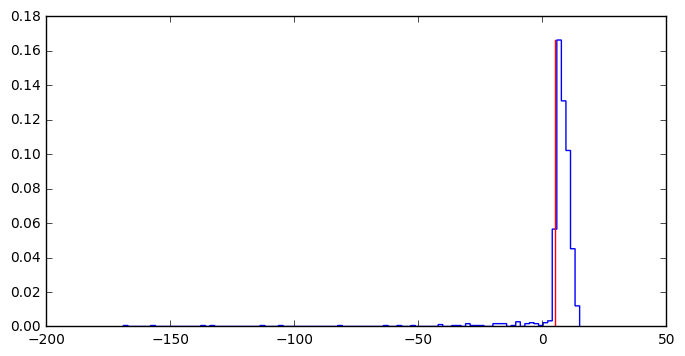

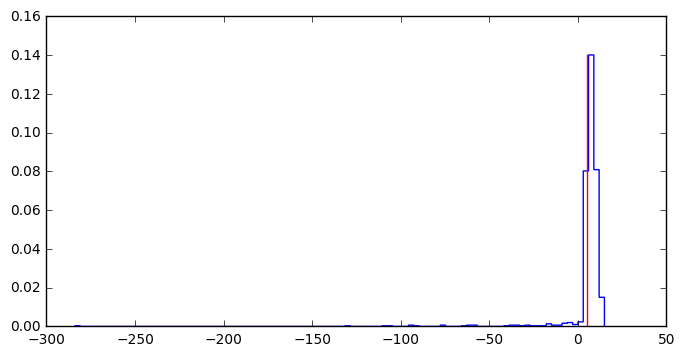

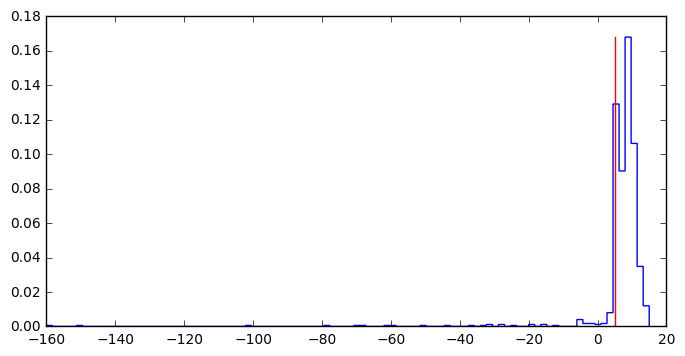

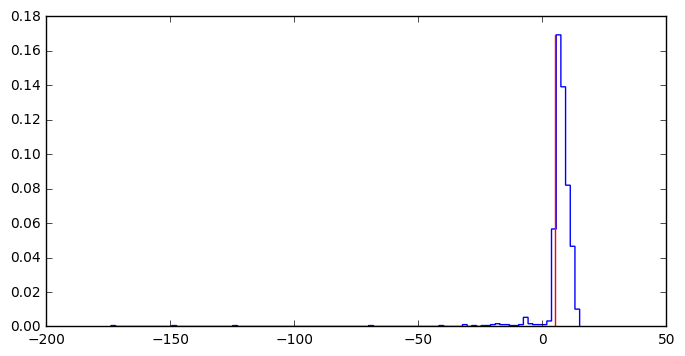

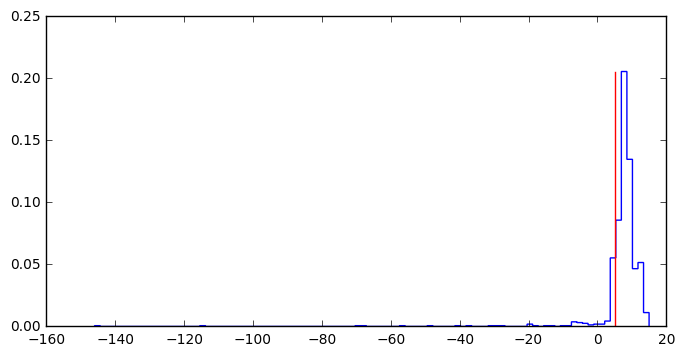

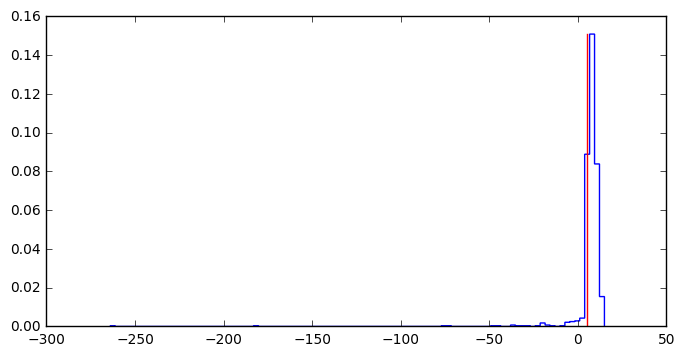

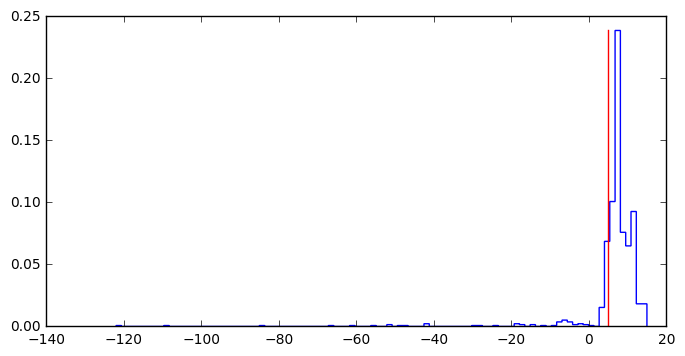

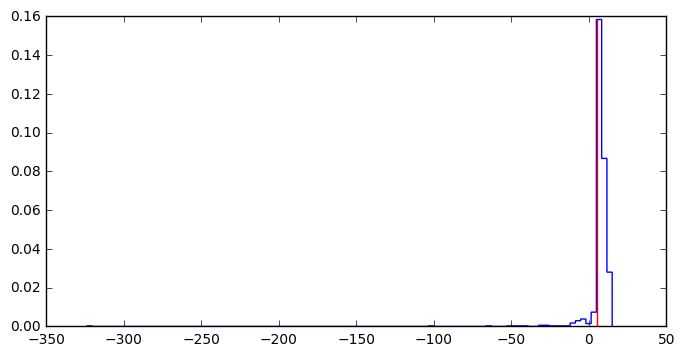

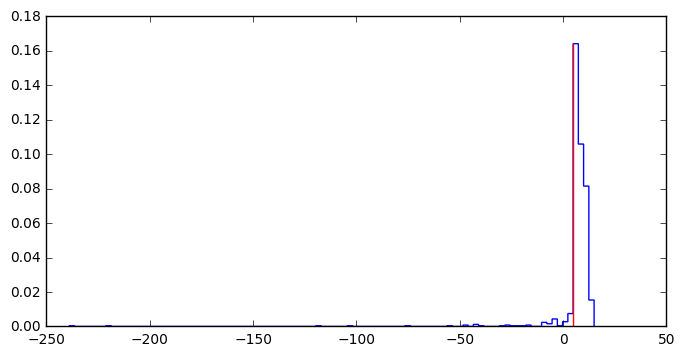

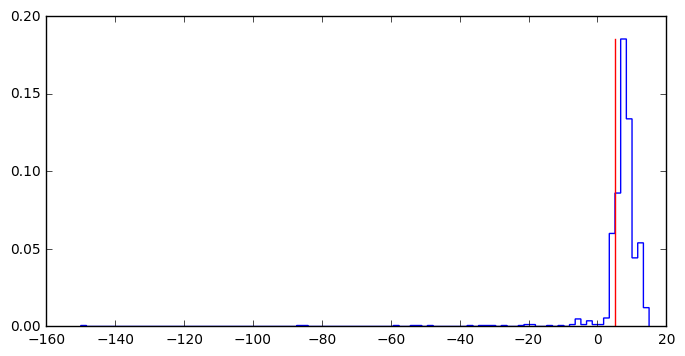

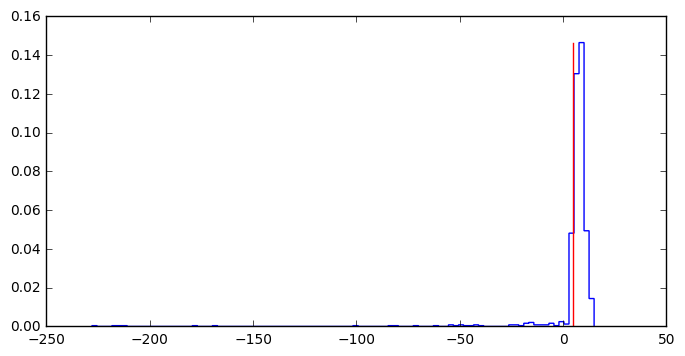

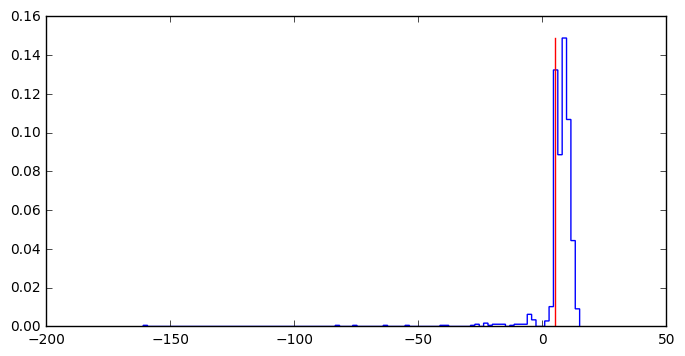

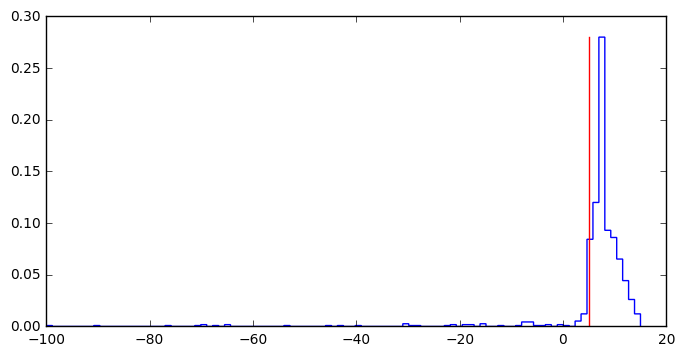

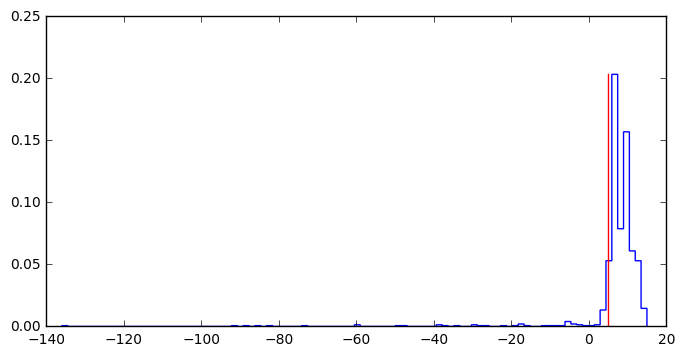

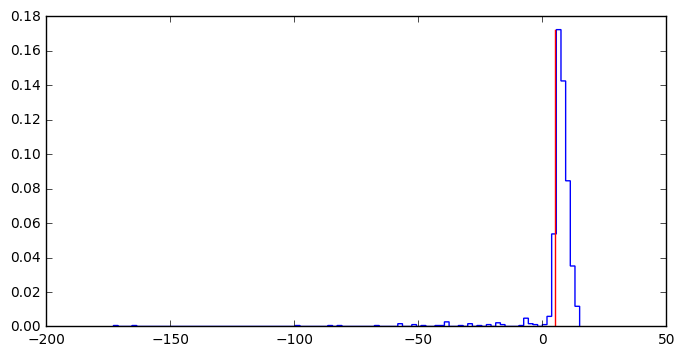

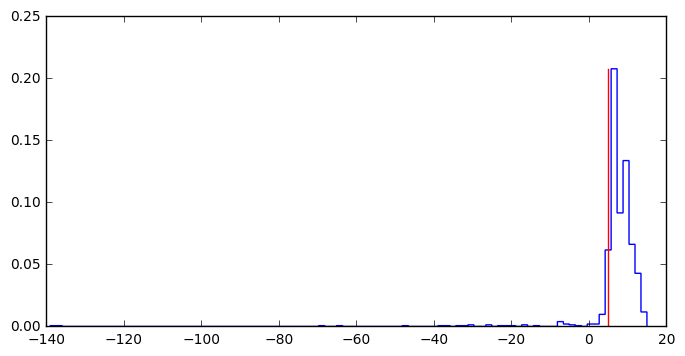

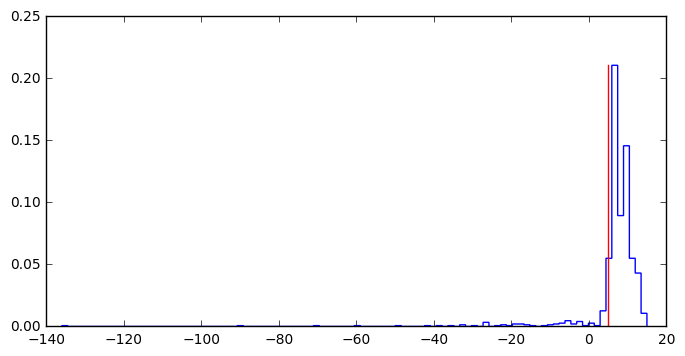

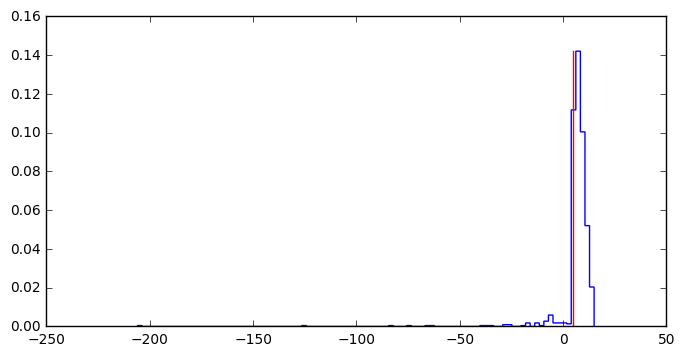

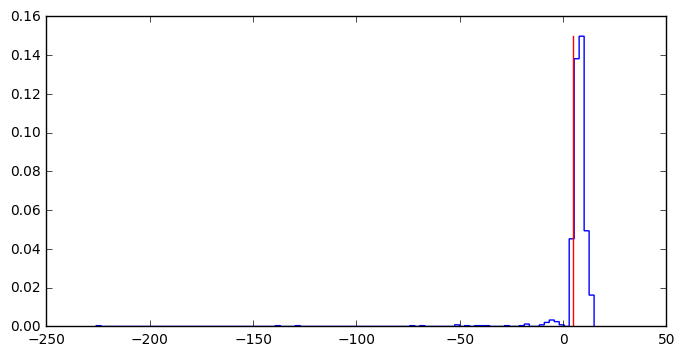

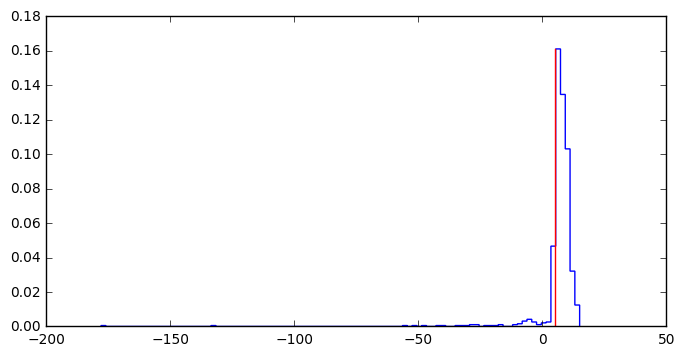

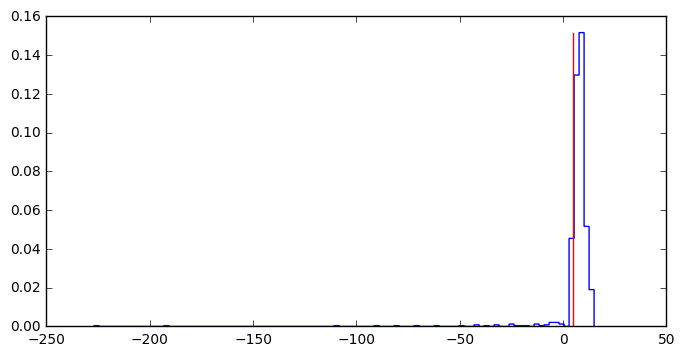

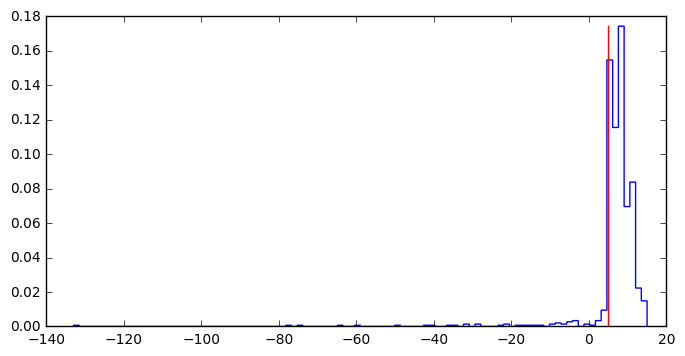

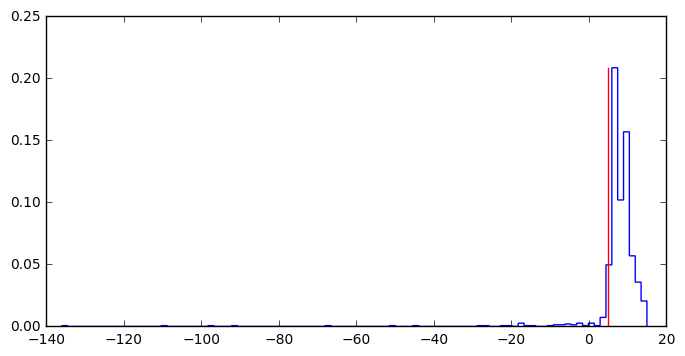

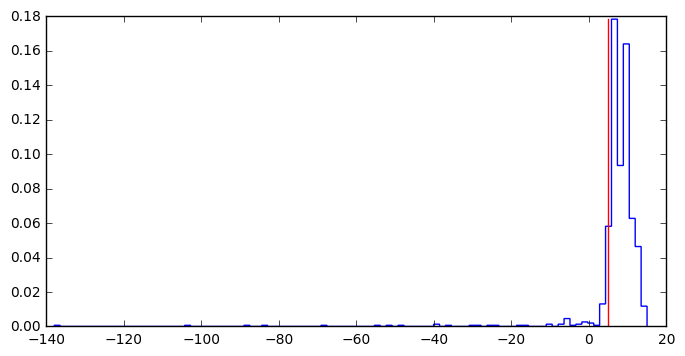

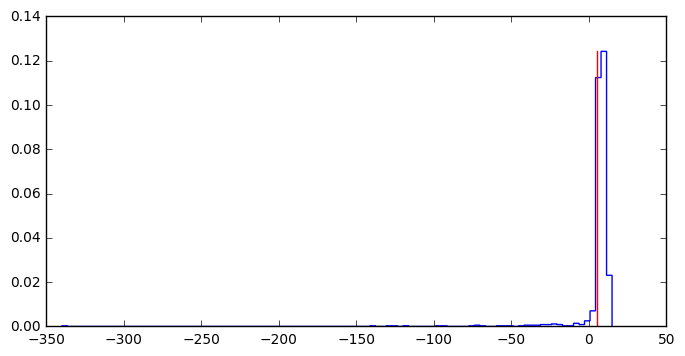

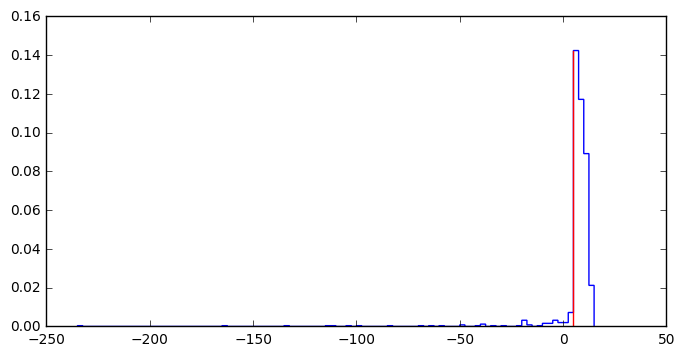

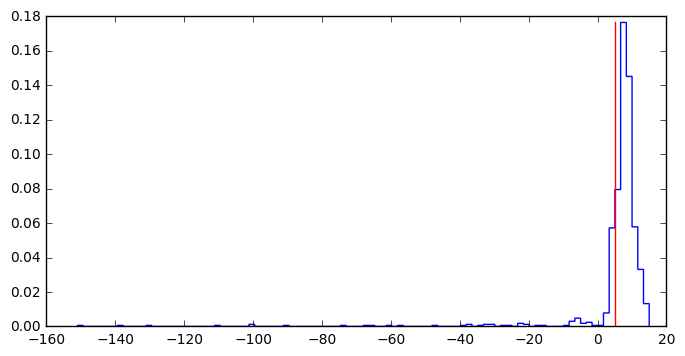

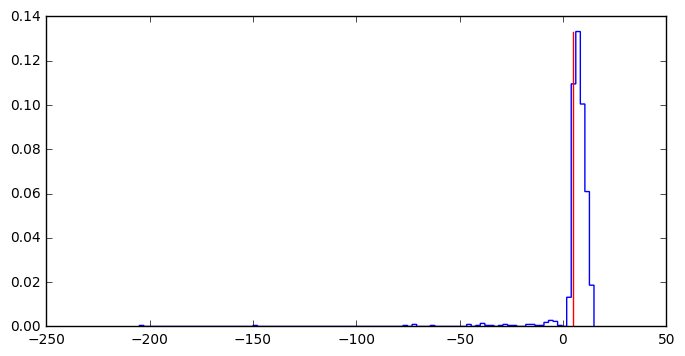

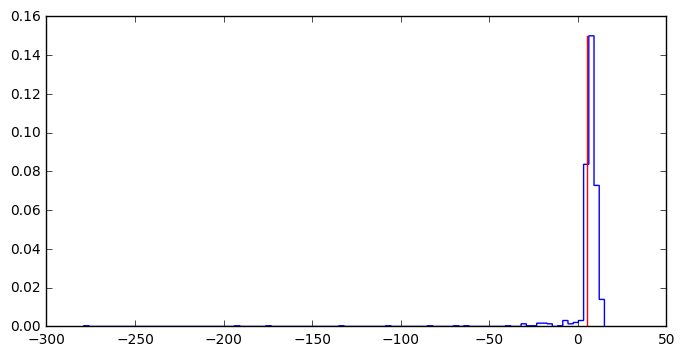

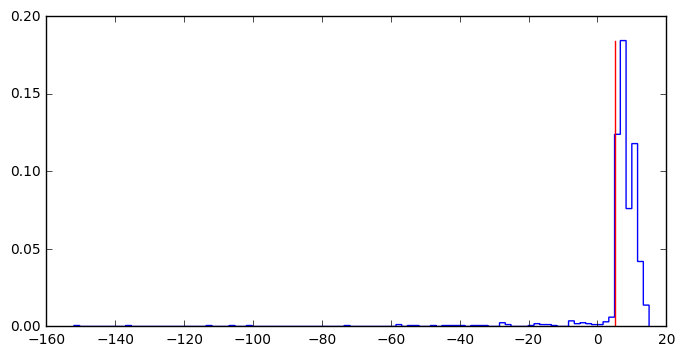

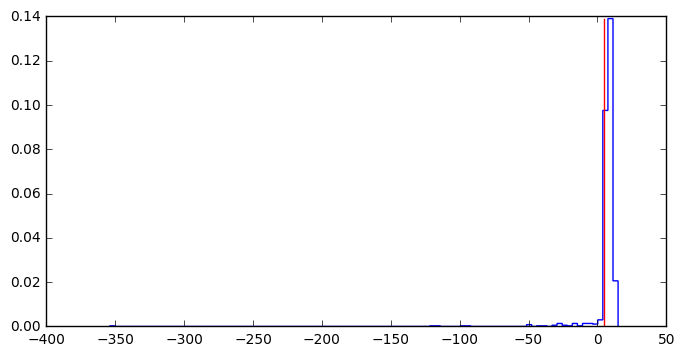

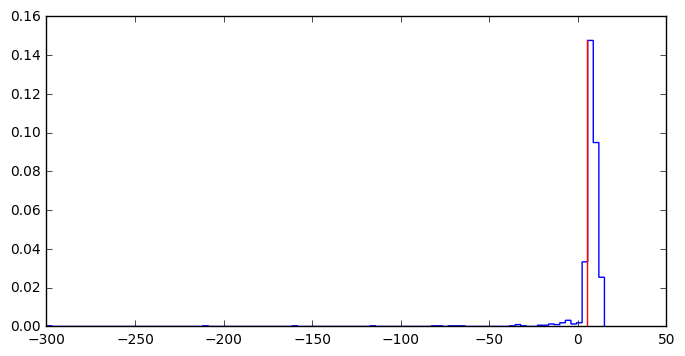

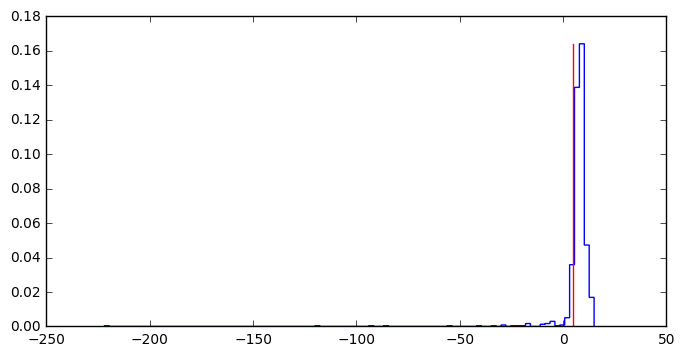

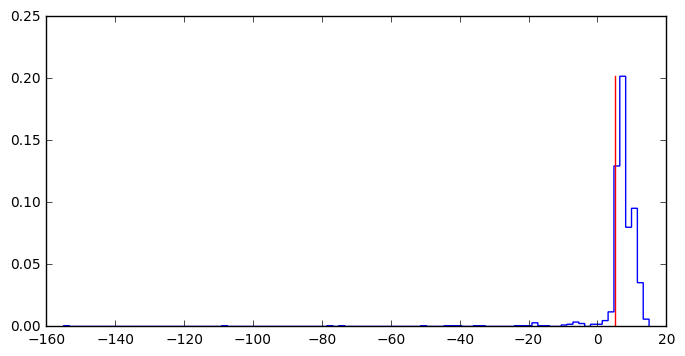

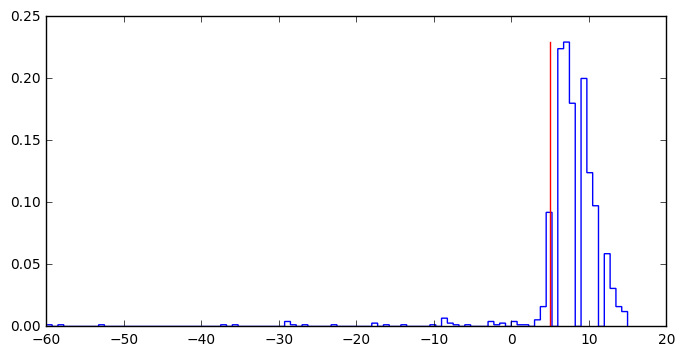

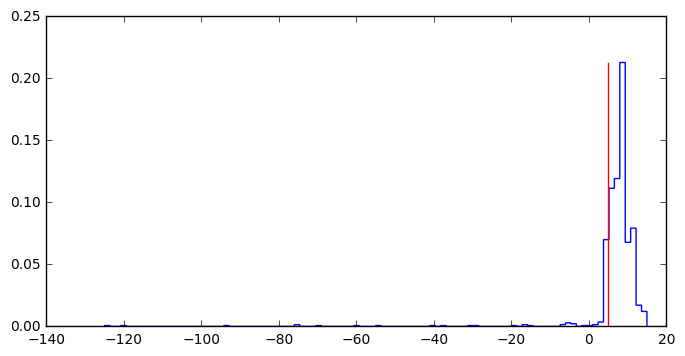

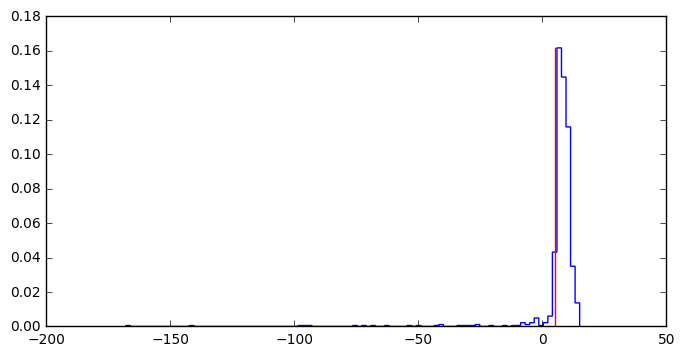

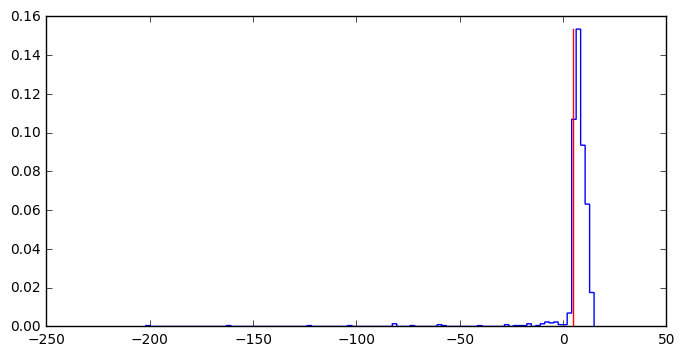

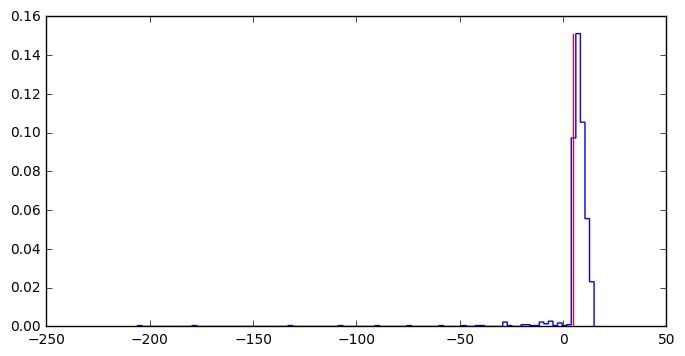

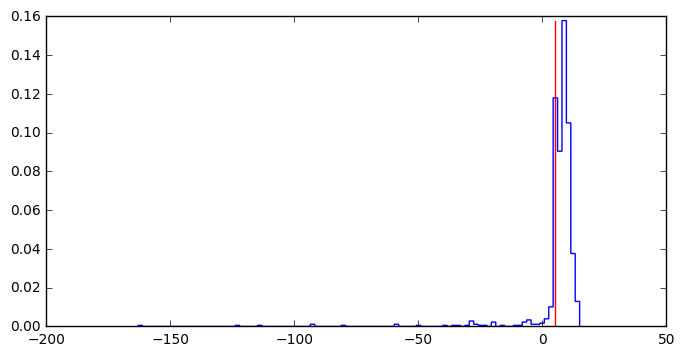

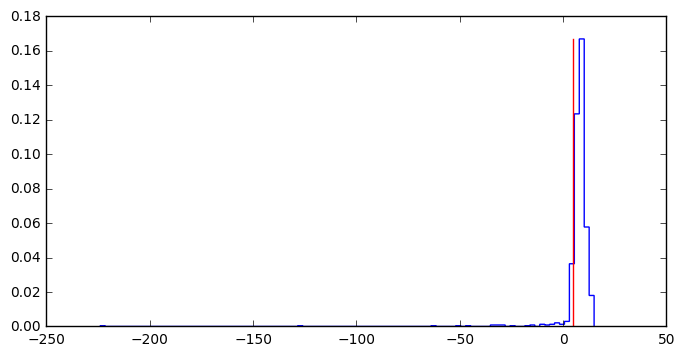

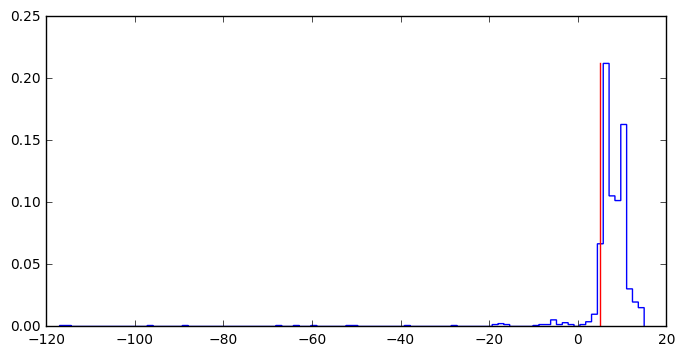

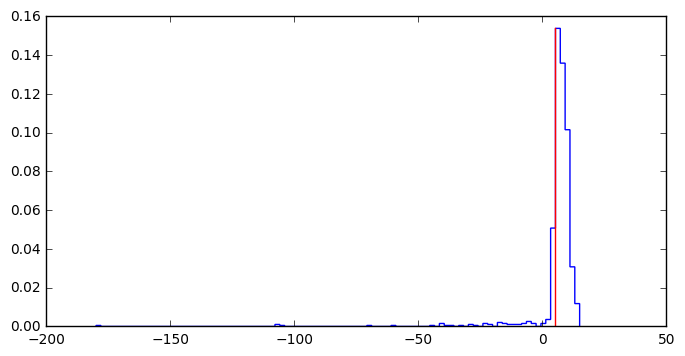

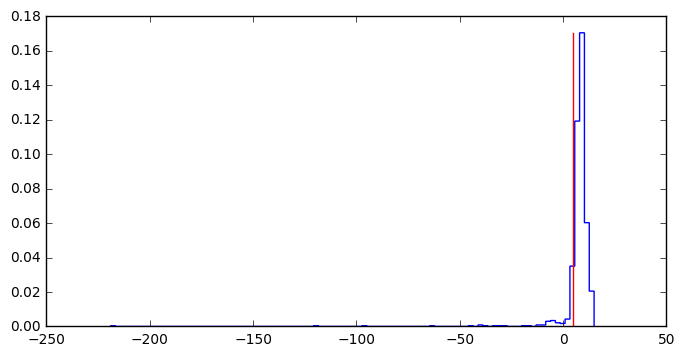

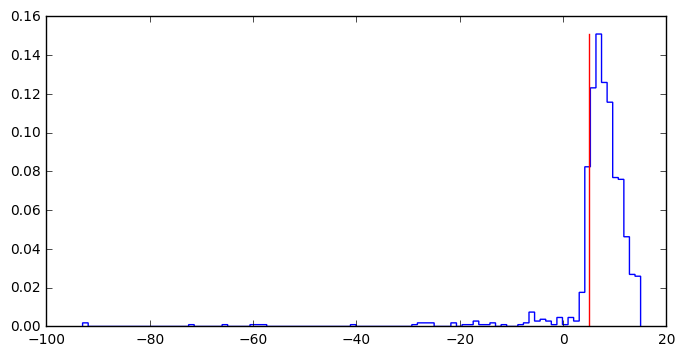

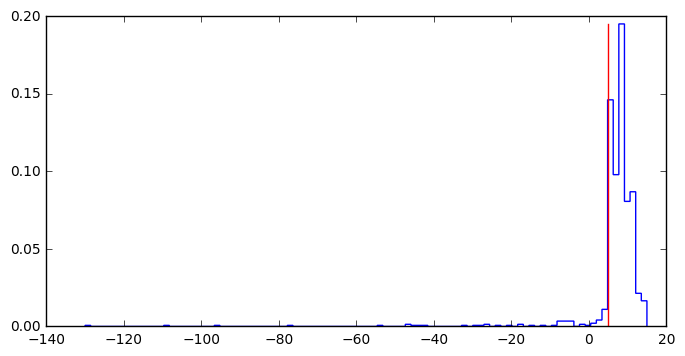

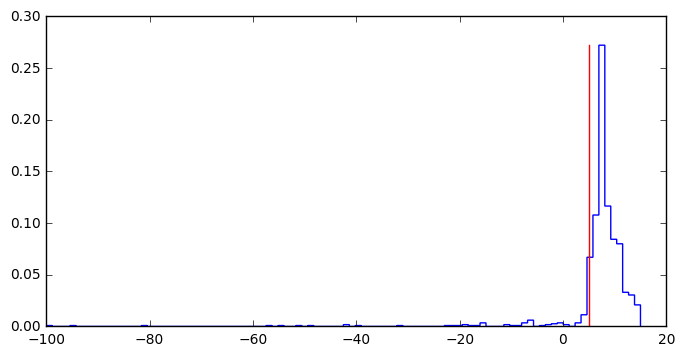

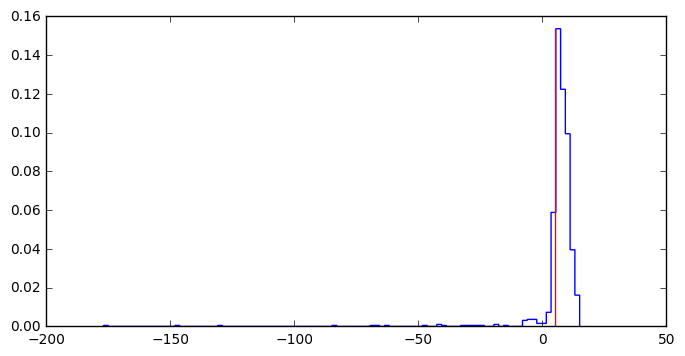

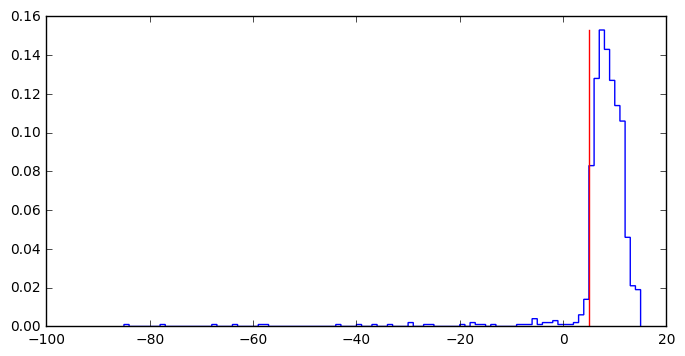

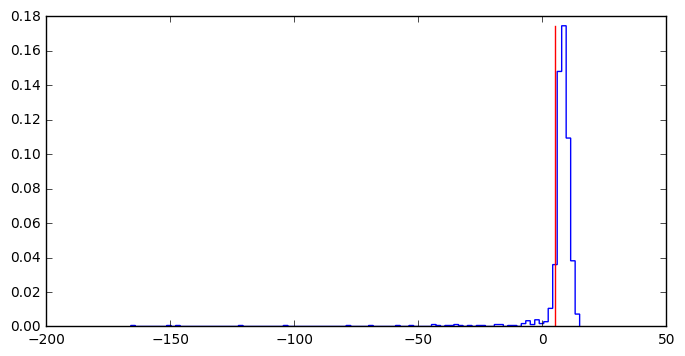

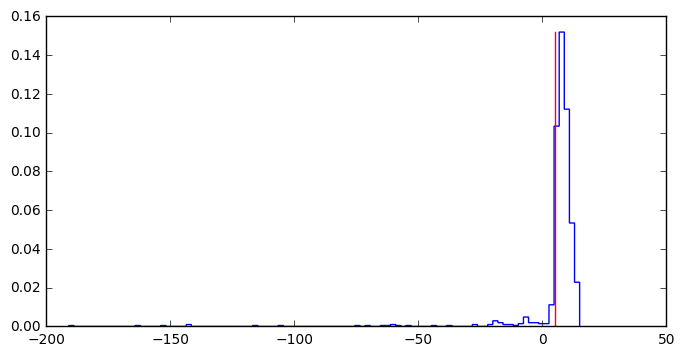

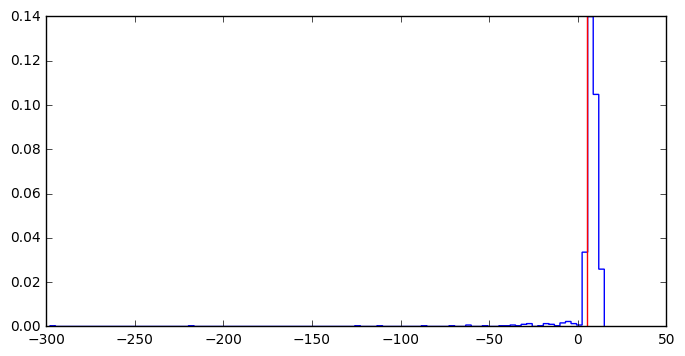

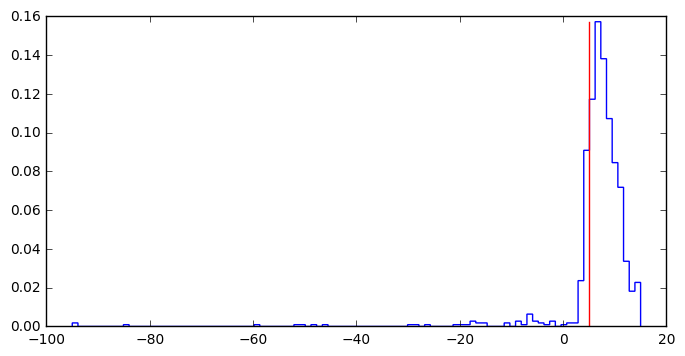

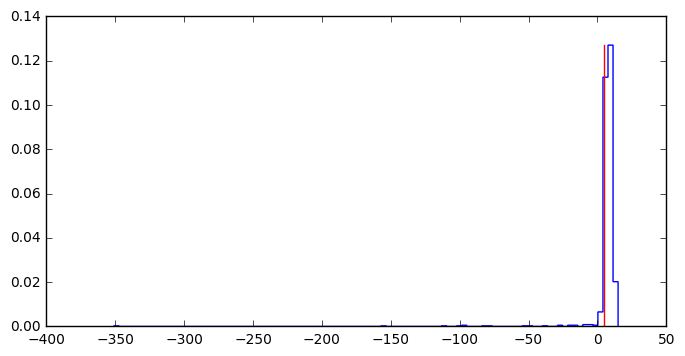

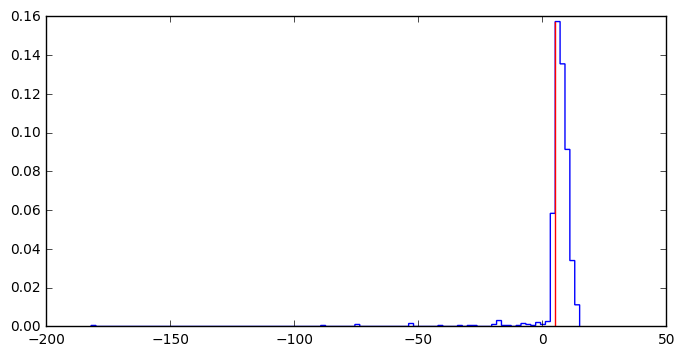

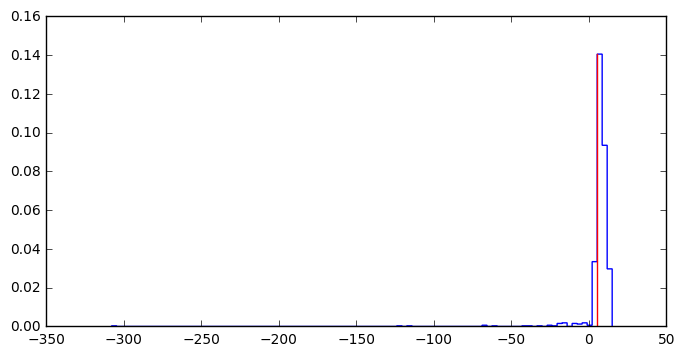

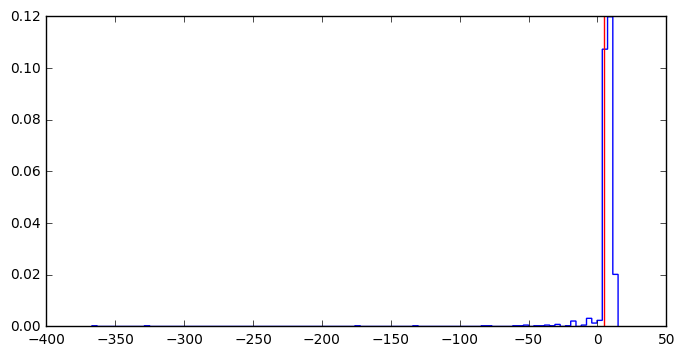

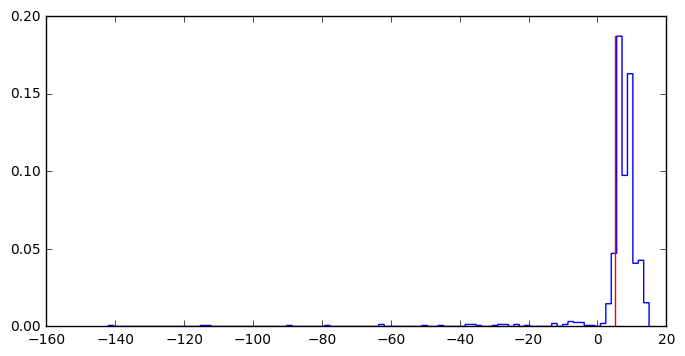

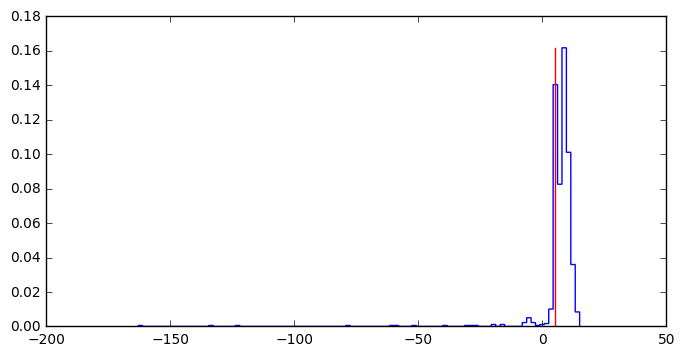

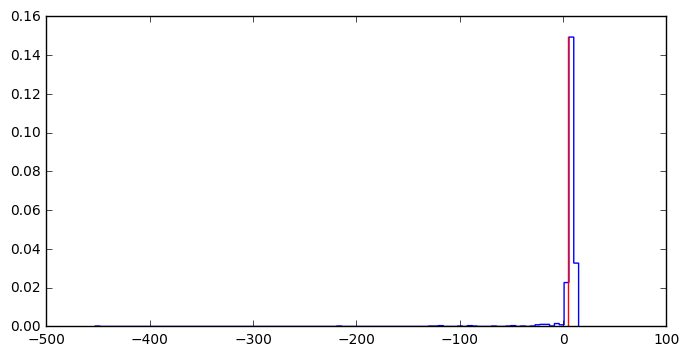

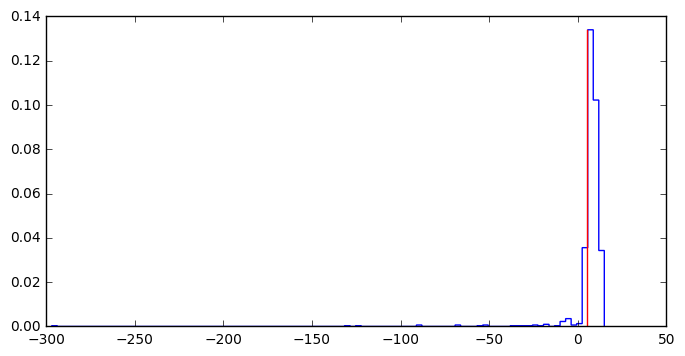

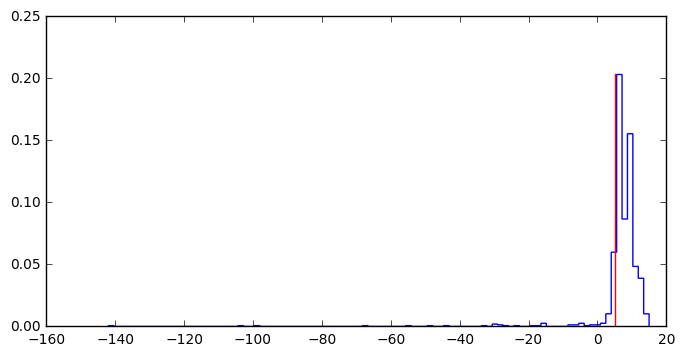

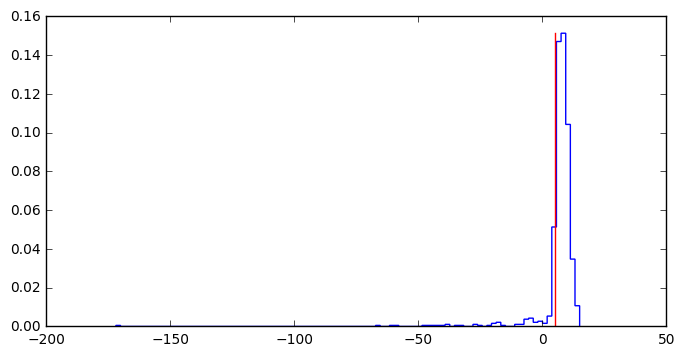

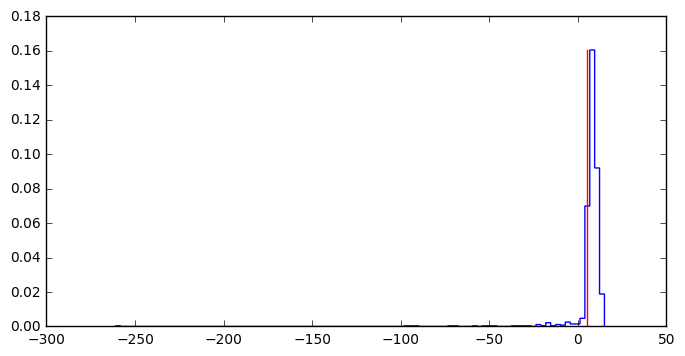

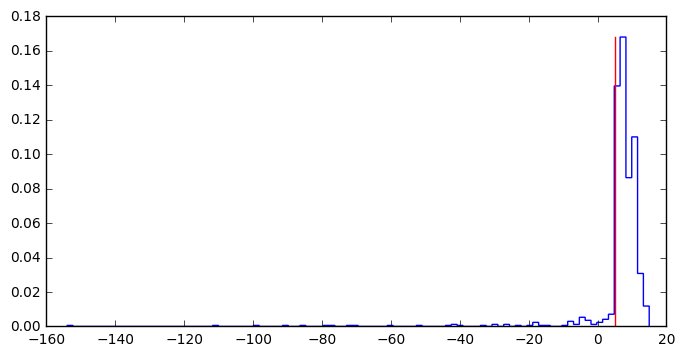

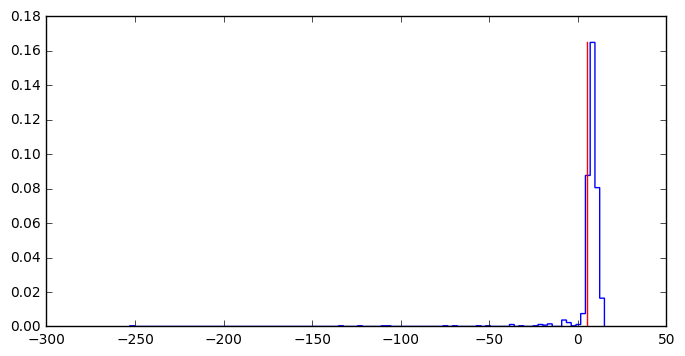

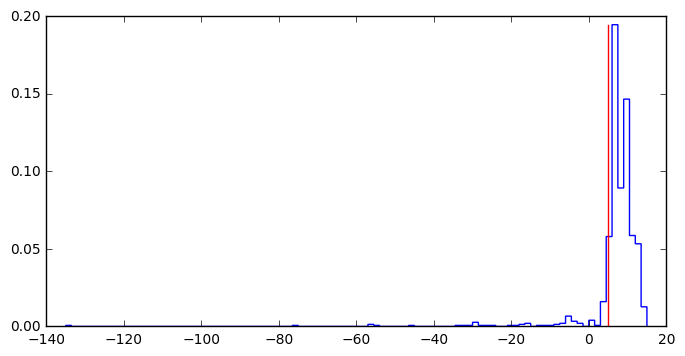

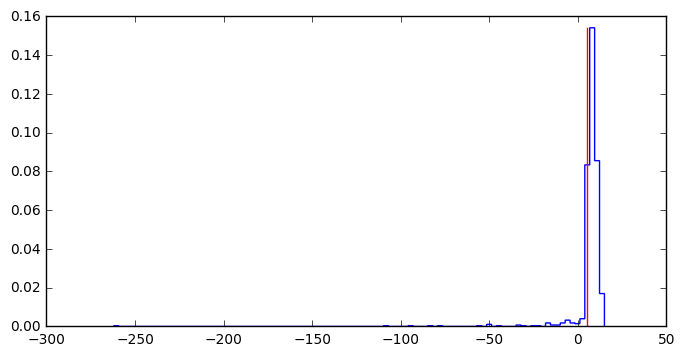

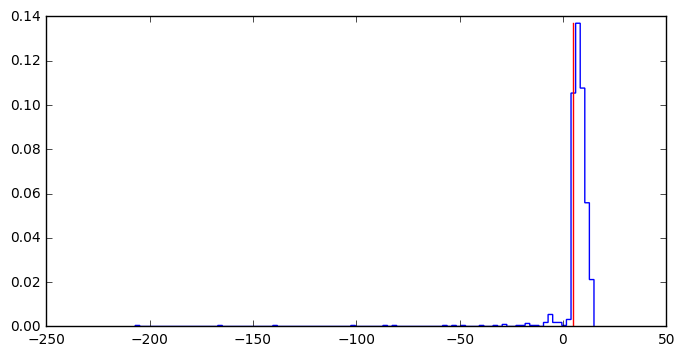

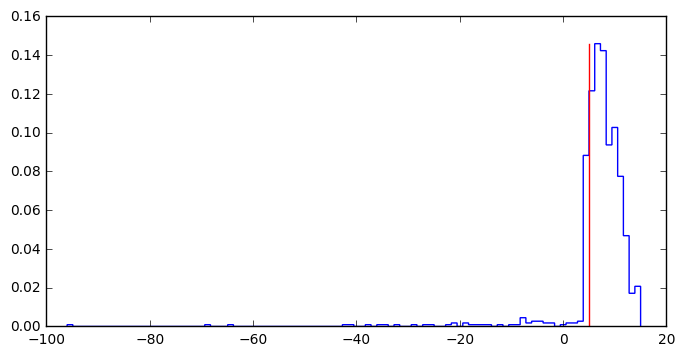

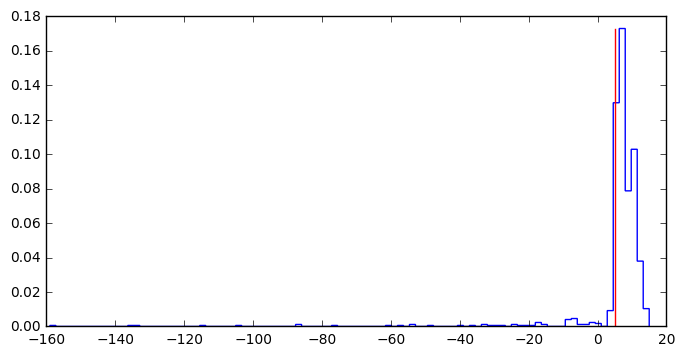

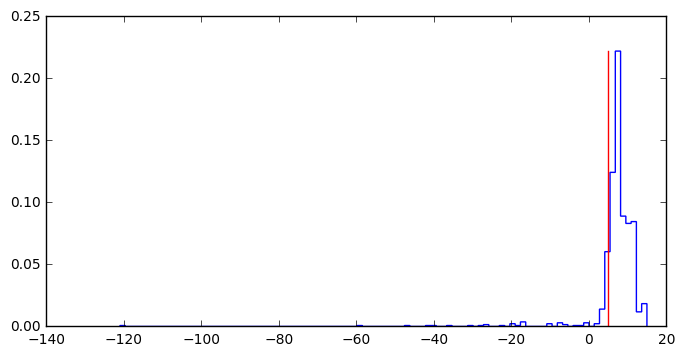

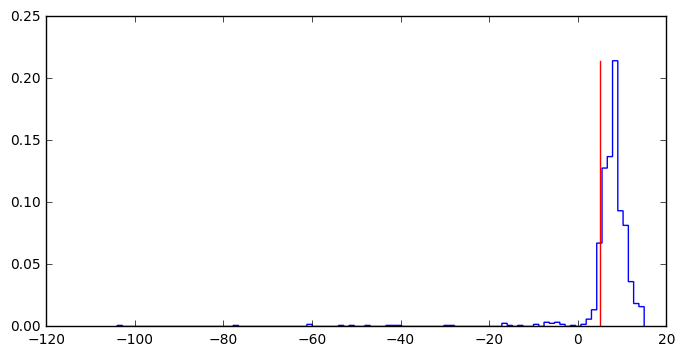

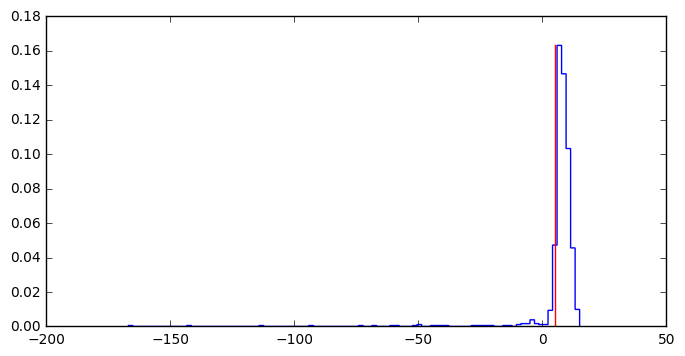

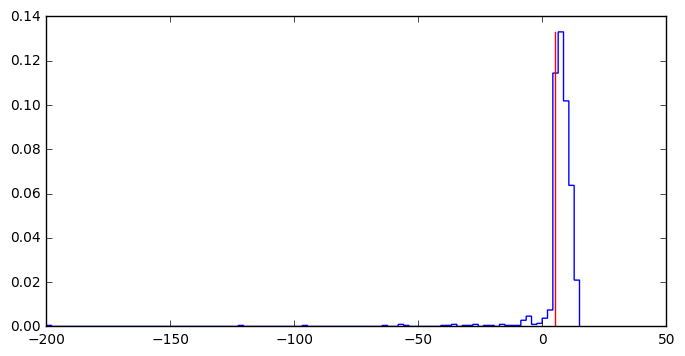

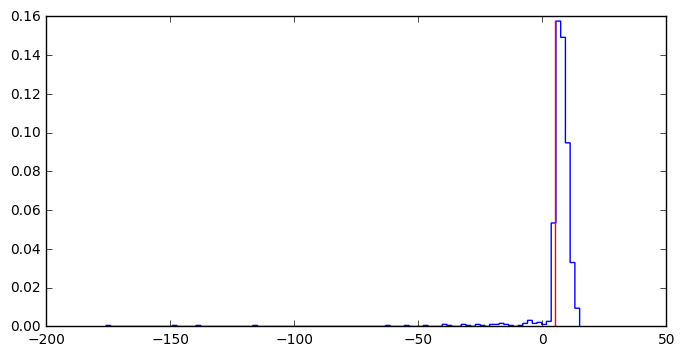

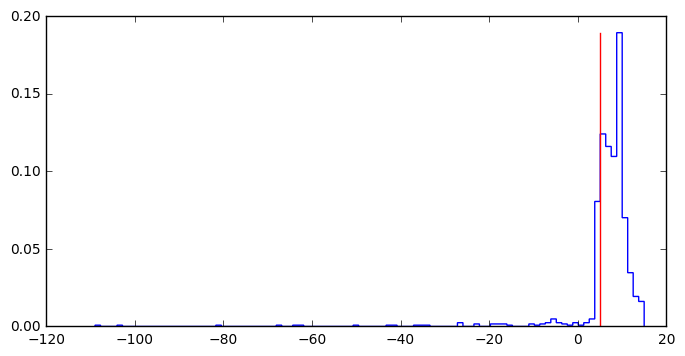

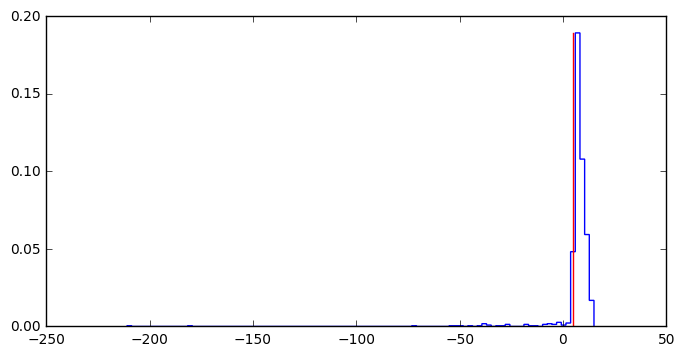

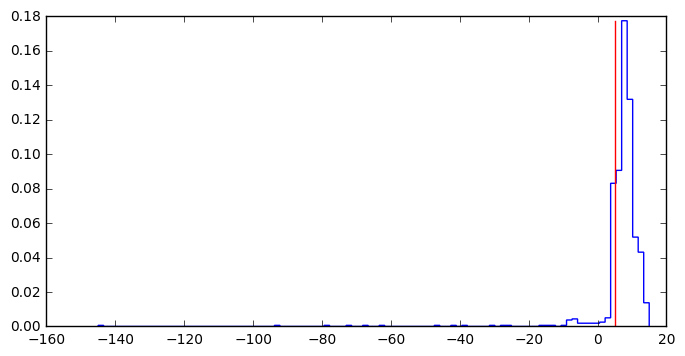

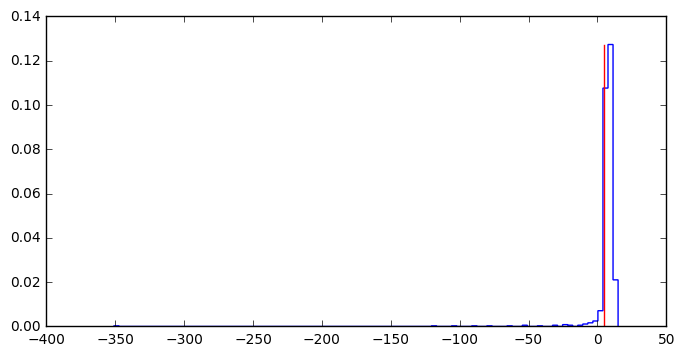

In [65]:
n_samples = 1000  #sample this many samples
percentile = 10  #take this percent of session with highest rewards
smoothing = 0.01 #add this thing to all counts for stability

mean_rewards = []
thresholds = []

for i in range(100):
        
    sessions = [generate_session() for _ in range(n_samples)]
    
    batch_states,batch_actions,batch_rewards = map(np.array,zip(*sessions))

    #batch_states: a list of lists of states in each session
    #batch_actions: a list of lists of actions in each session
    #batch_rewards: a list of floats - total rewards at each session
    
    threshold = np.percentile(batch_rewards, percentile)
    if len(thresholds) > 0 and thresholds[-1] > 0:
        threshold = max(threshold, thresholds[-1] * 0.5)
    
    ind = (threshold <= batch_rewards)
    
    elite_states = batch_states[ind]
    elite_actions = batch_actions[ind]
    
    elite_states, elite_actions = map(np.concatenate,[elite_states,elite_actions])
    #hint on task above: use np.percentile and numpy-style indexing
    
    #count actions from elite states
    elite_counts = np.zeros_like(policy) + smoothing
    
    for s,a in zip(elite_states, elite_actions):
        elite_counts[s, a] += 1

    policy = elite_counts / elite_counts.sum(axis=1).reshape(-1,1)
    
    mean_rewards.append(np.mean(batch_rewards))
    thresholds.append(threshold)
    
    
    plt.figure(figsize=(8,4))
    hist = plt.hist(batch_rewards, bins=100, histtype='step', normed=True)
    plt.plot([threshold, threshold], [0, hist[0].max()], 'r')
    display.clear_output(wait=True)
    display.display(plt.gcf())

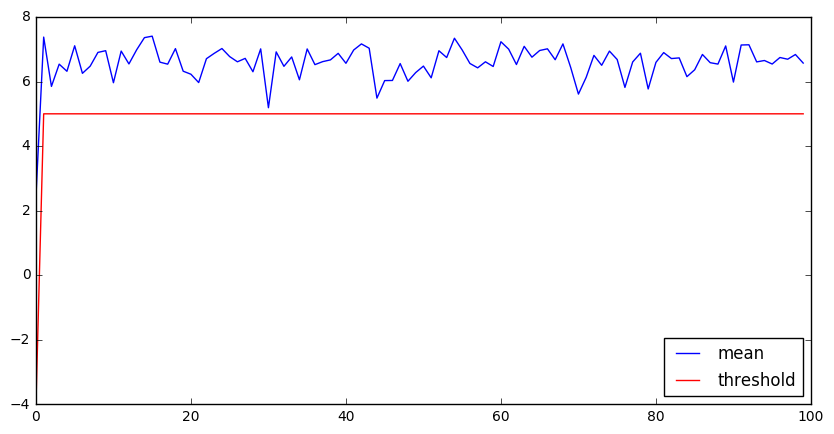

In [66]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(len(mean_rewards)), mean_rewards, 'b')
plt.plot(np.arange(len(mean_rewards)), thresholds, 'r')
plt.legend(['mean', 'threshold'], loc=4)

Следующая ячейка к пункту 1.4

In [72]:
np.percentile(batch_rewards, 75)

10.0

# Approximate (deep) crossentropy method

In this section we will train a neural network policy for continuous action space game

In [5]:
env = gym.make("LunarLander-v2")
env.reset()
n_actions = env.action_space.n

[2017-02-26 19:16:37,579] Making new env: LunarLander-v2


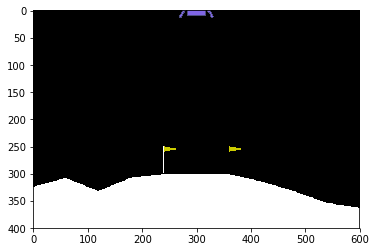

In [6]:
plt.imshow(env.render("rgb_array"))

In [7]:
#create agent
from sklearn.neural_network import MLPClassifier
agent = MLPClassifier(hidden_layer_sizes=(200, 200),
                      activation='tanh',
                      warm_start=True, #keep progress between .fit(...) calls
                      max_iter=1 #make only 1 iteration on each .fit(...)
                     )
#initialize agent to the dimension of state an amount of actions
agent.fit([env.reset()] * n_actions,range(n_actions));


/root/env/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


In [15]:
def generate_session(t_max=250):
    
    states,actions = [],[]
    total_reward = 0
    
    s = env.reset()
    
    for t in range(t_max):
        
        #predict array of action probabilities
        probs = agent.predict_proba([s])[0] 
        
        a = np.random.choice(np.arange(n_actions), p=probs)
        
        new_s,r,done,info = env.step(a)
        
        #record sessions like you did before
        states.append(s)
        actions.append(a)
        total_reward+=r
        
        s = new_s
        if done: break
    return states,actions,total_reward

In [9]:
n_samples = 100
percentile = 25
smoothing = 0.02

mean_rewards = []
thresholds = []

prev_states = []
prev_actions = []
prev_rewards = []

В последствии оказалось, что лучше всего рассматривать только короткие сессии. Момент, когда я это обнаружил - как раз скачок на графике :)

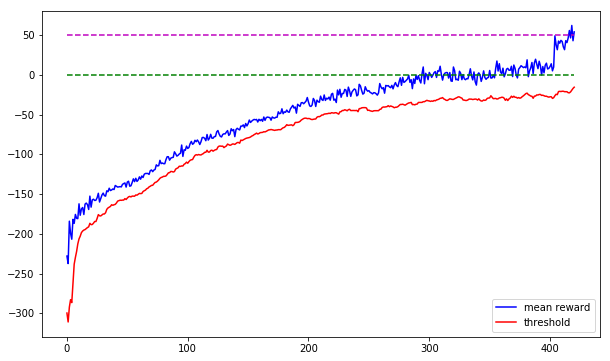

In [ ]:
for i in range(500):
    #generate new sessions
    sessions = [generate_session() for _ in range(n_samples)]

    batch_states,batch_actions,batch_rewards = map(np.array,zip(*sessions))
    #batch_states: a list of lists of states in each session
    #batch_actions: a list of lists of actions in each session
    #batch_rewards: a list of floats - total rewards at each session
    prev_states.extend(batch_states)
    prev_actions.extend(batch_actions)
    prev_rewards.extend(batch_rewards)
    
    if len(prev_actions) > 500:
        prev_actions = prev_actions[100:]
        prev_rewards = prev_rewards[100:]
        prev_states = prev_states[100:]
        
    threshold = np.percentile(prev_rewards, percentile)
    
#     if len(thresholds) > 0:
#         if thresholds[-1] < 0:
#             threshold = max(threshold, 1.5 * thresholds[-1])
#         else:
#             threshold = max(threshold, 0.7 * thresholds[-1])
        
    
    ind = (threshold <= prev_rewards)
    
    elite_states = np.array(prev_states)[ind]
    elite_actions = np.array(prev_actions)[ind]
    
    elite_states, elite_actions = map(np.concatenate,[elite_states,elite_actions])
    #elite_states: a list of states from top games
    #elite_actions: a list of actions from top games
    
    agent.fit(elite_states, elite_actions)
    
    mean_rewards.append(np.mean(batch_rewards))
    thresholds.append(threshold)
    
    plt.figure(figsize=(10,6))
    n = len(mean_rewards)
    plt.plot(np.arange(n), mean_rewards, 'b')
    plt.plot(np.arange(n), thresholds, 'r')
    plt.plot(np.arange(n), np.zeros(n), 'g--')
    plt.plot(np.arange(n), np.ones(n) * 50, 'm--')
    plt.legend(['mean reward', 'threshold'], loc=4)
    display.clear_output(wait=True)
    display.display(plt.gcf())

### CartPole

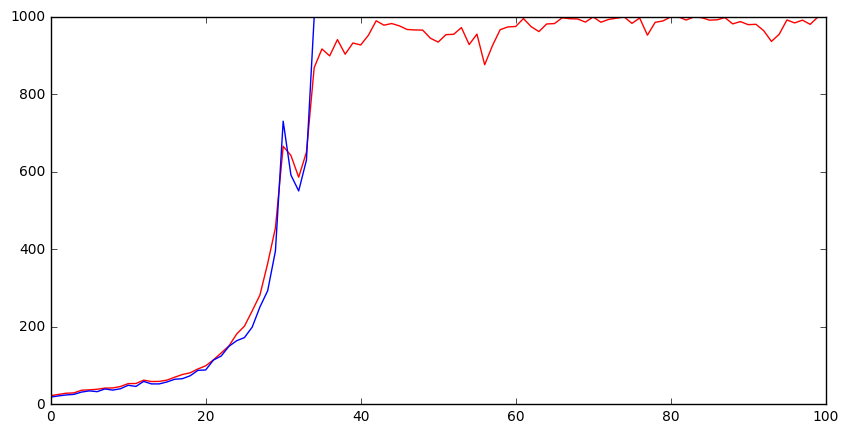

In [81]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(len(mean_rewards)), mean_rewards, 'r')
plt.plot(np.arange(len(mean_rewards)), thresholds, 'b-')

# Results

In [96]:
env=gym.make("CartPole-v0");env.reset();

[2017-02-25 20:31:30,901] Making new env: CartPole-v0


In [98]:
rm -rf ./videos/

In [99]:
#record sessions
import gym.wrappers
env = gym.wrappers.Monitor(env,directory="videos",force=True)
sessions = [generate_session() for _ in range(100)]
env.close()
#unwrap
env = env.env.env

[2017-02-25 20:32:06,757] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-02-25 20:32:06,762] Creating monitor directory videos
[2017-02-25 20:32:06,765] Starting new video recorder writing to /home/mlevkov/rl/Practical_RL/week1/videos/openaigym.video.3.11810.video000000.mp4
[2017-02-25 20:32:10,301] Starting new video recorder writing to /home/mlevkov/rl/Practical_RL/week1/videos/openaigym.video.3.11810.video000001.mp4
[2017-02-25 20:32:13,916] Starting new video recorder writing to /home/mlevkov/rl/Practical_RL/week1/videos/openaigym.video.3.11810.video000008.mp4
[2017-02-25 20:32:17,834] Starting new video recorder writing to /home/mlevkov/rl/Practical_RL/week1/videos/openaigym.video.3.11810.video000027.mp4
[2017-02-25 20:32:22,209] Starting new video recorder writing to /home/m

In [114]:
monitor = gym.monitoring._open_monitors()[0]

In [115]:
monitor.close()

[2017-02-25 20:36:18,984] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/mlevkov/rl/Practical_RL/week1/videos')


In [116]:
#upload to gym
gym.upload("./videos/",api_key='sk_4jCBY9XTQJCSQ0CSYTPhMg') #you'll need me later

#Warning! If you keep seeing error that reads something like"DoubleWrapError",
#run env=gym.make("CartPole-v0");env.reset();

[2017-02-25 20:36:23,886] [CartPole-v0] Uploading 100 episodes of training data
/usr/local/lib/python2.7/dist-packages/requests/packages/urllib3/util/ssl_.py:334: SNIMissingWarning: An HTTPS request has been made, but the SNI (Subject Name Indication) extension to TLS is not available on this platform. This may cause the server to present an incorrect TLS certificate, which can cause validation failures. You can upgrade to a newer version of Python to solve this. For more information, see https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  SNIMissingWarning
/usr/local/lib/python2.7/dist-packages/requests/packages/urllib3/util/ssl_.py:132: InsecurePlatformWarning: A true SSLContext object is not available. This prevents urllib3 from configuring SSL appropriately and may cause certain SSL connections to fail. You can upgrade to a newer version of Python to solve this. For more information, see https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnin

In [ ]:
#show video
from IPython.display import HTML
import os

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./videos/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos/"+video_names[-1])) #this may or may not be _last_ video. Try other indices

# Homework part I

### Tabular correntropy method

You may have noticed that the taxi problem quickly converges from -10k to aroung -500 score (+- 500) and stays there. This is in part because taxi-v2 has some hard-coded randomness in the environment. Other reason is that the percentile was chosen poorly.

### Tasks
- <strike>__1.1__</strike> (1 pt) Modify the tabular CEM (CrossEntropyMethod) code to plot distribution of rewards and threshold on each tick.
- <strike>__1.2__</strike> (2 pts) Find out how the algorithm performance changes if you change different percentile and different n_samples.

Чем большее число сессий мы берем, тем лучше наш алгоритм, т.к. мы лучше приближаем распределение на действиях (стратегию).
По поводу перцентили же - наоборот: ее лучше сделать поменьше, чем было указано изначально(50). Это можно объяснить примерно той же интуицией, что и в exploitation-exploration. Лучше брать часть стратегий, которые являются не самыми хорошими, но при этом показывают достаточно неплохой результат. Также следует учитывать, что со временем все больше игр становятся "хорошими" - поэтому, если мы берем, например, 10-перцентиль, мы все равно получаем игры с хорошими скорами.


- <strike>__1.3__</strike> (2 pts) Tune the algorithm to end up with positive average score.
- <strike>__1.4 bonus__</strike> (1 pt) Try to achieve a distribution where 25% or more samples score above +9.0
- __1.5 bonus__ (2 pts) Solve and upload [Taxi-v1](https://gym.openai.com/envs/Taxi-v1) to the openai gym.

It's okay to modify the existing code.


# Homework part II

### Deep crossentropy method

By this moment you should have got enough score on [CartPole-v0](https://gym.openai.com/envs/CartPole-v0) to consider it solved (see the link). It's time to upload the result and get to something harder.

* if you have any trouble with CartPole-v0 and feel stuck, feel free to ask us or your peers for help.

### Tasks

* __2.1__ Go to the [gym site](http://gym.openai.com/), register and obtain __api key__.
* __2.2__ (1 pt) Upload your result to gym via gym.upload (see Results tab above, the line you need is commented)
* __2.3__ (3 pts) Pick one of environments: MountainCar-v0 or LunarLander-v2 (or both) and solve it.
  * For MountainCar, learn to finish it in __less than 180 steps__
  * For LunarLander, learn to get reward of __at least +50__
  * See the tips section below, it's kinda important.
  
  
* __2.4__ (1+ pt) Devise a way to speed up training at least 2x against the default version
  * Obvious improvement: use [joblib](https://www.google.com/search?client=ubuntu&channel=fs&q=joblib&ie=utf-8&oe=utf-8)
  * Try re-using samples from 3-5 last iterations when computing threshold and training
  * Experiment with amount of training iterations and learning rate of the neural network (see params)
  
  
### Tips
* Gym page: [mountaincar](https://gym.openai.com/envs/MountainCar-v0), [lunarlander](https://gym.openai.com/envs/LunarLander-v2)
* Sessions for MountainCar may last for 10k+ ticks. Make sure ```t_max``` param is at least 10k.
 * Also it may be a good idea to cut rewards via ">" and not ">=". If 90% of your sessions get reward of -10k and 20% are better, than if you use percentile 20% as threshold, R >= threshold __fails cut off bad sessions__ whule R > threshold works alright.
* _issue with gym_: Some versions of gym limit game time by 200 ticks. This will prevent cem training in most cases. Make sure your agent is able to play for the specified __t_max__, and if it isn't, try `env = gym.make("MountainCar-v0").env` or otherwise get rid of TimeLimit wrapper.
* If you use old _swig_ lib for LunarLander-v2, you may get an error. See this [issue](https://github.com/openai/gym/issues/100) for solution.
* If it won't train it's a good idea to plot reward distribution and record sessions: they may give you some clue. If they don't, call course staff :)
* 20-neuron network is probably not enough, feel free to experiment.
* __Please upload the results to openai gym and send links to all submissions in the e-mail__

### Bonus tasks

* __2.5 bonus__ Try to find a network architecture and training params that solve __both__ environments above (_Points depend on implementation_)

* __2.6 bonus__ Solve continuous action space task with `MLPRegressor` or similar.
  * [MountainCarContinuous-v0](https://gym.openai.com/envs/MountainCarContinuous-v0), [LunarLanderContinuous-v2](https://gym.openai.com/envs/LunarLanderContinuous-v2) (4+ points if it works)
  
* __2.7 bonus__ Use any deep learning framework of your choice to implement policy-gradient (see lectures) on any of those envs (4 +1 per env):
  * CartPole-v0
  * MountainCar-v0
  * LunarLander-v2
  * See __tips on policy gradient__ below.
  

* __2.8 bonus__ take your favorite deep learning framework and try to get above random in [Atari Breakout](https://gym.openai.com/envs/Breakout-v0) with crossentropy method over a convolutional network.
  * Expect at least +10 points if you get this up and running, no deadlines apply ! 
  * __See tips below on where to start, they're cruicially important__

### Tips on policy gradient

* The loss function is very similar to crossentropy method. You can get away with using rewards as  __sample_weights__.
* If your algorithm converges to a poor strategy, try regularizing with entropy or just somehow prevent agent from picking actions deterministically (e.g. when probs = 0,0,1,0,0)
* We will use `lasagne` later in the course so you can try to [learn it](http://lasagne.readthedocs.io/en/latest/user/tutorial.html).
* If you don't want to mess with theano just yet, try [keras](https://keras.io/getting-started/sequential-model-guide/) or [mxnet](http://mxnet.io/tutorials/index.html).


 ### Tips on atari breakout

* There's all the pre-processing and tuning done for you in the code below
* Once you got it working, it's probably a good idea to pre-train with autoencoder or something
* We use last 4 frames as observations to account for ball velocity
* The code below requires ```pip install Image``` and ```pip install gym[atari]```

In [ ]:
from breakout import make_breakout

env = make_breakout()
env.action_space

In [ ]:
#get the initial state
s = env.reset()
print (s.shape)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
#plot first observation. Only one frame
plt.imshow(s.swapaxes(1,2).reshape(-1,64).T)

In [ ]:
#next frame
new_s,r,done, _ = env.step(env.action_space.sample())
plt.imshow(new_s.swapaxes(1,2).reshape(-1,64).T)

In [ ]:
#after 10 frames
for _ in range(10):
    new_s,r,done, _ = env.step(env.action_space.sample())

plt.imshow(new_s.swapaxes(1,2).reshape(-1,64).T)

In [ ]:
< tons of your code here or elsewhere >